# Load the Data
## Peeringdb

In [1]:
import json
from pathlib import Path
import pandas as pd

filepath = Path('../../preprocessing/data/peeringdb/peeringdb_2_dump_2025_10_21.json')

with filepath.open('r', encoding='utf-8') as f:
    dump = json.load(f)

# extract the net.data section and load into a DataFrame
net_data = dump.get('net', {}).get('data')
if net_data is None:
    raise KeyError("JSON does not contain 'net' -> 'data' structure")

net_df = pd.DataFrame(net_data)
net_df['asn'] = net_df['asn'].astype(int)
net_df = net_df[net_df['info_type'] != '']

# show a quick preview
net_df.head()

,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,policy_ratio,policy_contracts,allow_ixp_update,status_dashboard,rir_status,rir_status_updated,logo,created,updated,status
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,True,Required,False,None,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-07-27T05:33:22Z,ok
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,False,Not Required,False,https://www.akamaistatus.com/,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-10-20T12:16:12Z,ok
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,False,Not Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-01-09T13:42:07Z,ok
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,True,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-08-12T06:33:30Z,ok
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,False,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-11-28T22:55:17Z,ok


# Caida AS Names

In [2]:
import io
with open('/workspaces/pytorch-gpu-2/preprocessing/data/caida/20251001.as-org2info.txt', 'r', newline='', encoding='utf-8') as input_file:
    lines = input_file.readlines()   
    # Buffers initialisieren
    aut_lines = []
    org_lines = []
    mode = None
    total_lines = len(lines)
    aut_count = 0
    org_count = 0 

    for i, line in enumerate(lines):
        line = line.strip()
        if line.startswith("# format:aut"):
            mode = "aut"
            continue
        elif line.startswith("# format:org_id"):
            mode = "org"
            continue
        elif line.startswith("#") or not line:
            # Andere Kommentar- oder Leerzeilen überspringen
            continue      
        if mode == "aut":
            aut_lines.append(line)
            aut_count += 1
        elif mode == "org":
            org_lines.append(line)
            org_count += 1
    # StringIO-Objekte aus den gesammelten Zeilen bauen
    aut_buffer = io.StringIO("\n".join(aut_lines))
    org_buffer = io.StringIO("\n".join(org_lines))
    # DataFrames einlesen
    aut_df = pd.read_csv(aut_buffer, sep="|",
                        names=["aut", "changed", "aut_name", "org_id", "opaque_id", "source"], usecols=["aut", "org_id", "source", "changed"])
    org_df = pd.read_csv(org_buffer, sep="|",
                        names=["org_id", "changed", "org_name", "country", "source"], usecols=["org_id", "org_name", "country"])

    # Join the DataFrames
    joined_df = pd.merge(aut_df, org_df, on="org_id", how="left")
joined_df.head()

,aut,changed,org_id,source,org_name,country
0,1,20240618.0,LPL-141-ARIN,ARIN,"Level 3 Parent, LLC",US
1,2,20231108.0,UNIVER-19-Z-ARIN,ARIN,University of Delaware,US
2,3,20100927.0,MIT-2-ARIN,ARIN,Massachusetts Institute of Technology,US
3,4,20230929.0,USC-32-Z-ARIN,ARIN,University of Southern California,US
4,5,20200723.0,WGL-117-ARIN,ARIN,WFA Group LLC,US


## Join both

In [3]:
peering_df_joined = pd.merge(net_df, joined_df, left_on='asn', right_on='aut', how='left')
peering_df_joined = peering_df_joined[['asn', 'org_name', 'country', 'source', 'info_type']]
peering_df_joined.head()

,asn,org_name,country,source,info_type
0,4436,"GTT Americas, LLC",US,ARIN,NSP
1,20940,Akamai International B.V.,NL,RIPE,Content
2,31800,DALnet,US,ARIN,Non-Profit
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Cable/DSL/ISP
4,22773,Cox Communications Inc.,US,ARIN,Cable/DSL/ISP


In [4]:
category_map = {
    "NSP": "Transit",
    "Content": "Content",
    "Cable/DSL/ISP": "Access",
    "Enterprise": "Enterprise",
    "Educational/Research": "Education/Research",
    "Non-Profit": "Enterprise",
    "Government": "Enterprise",
    "Route Server": "Network Services",
    "Route Collector": "Network Services",
    "Network Services": "Network Services",
    "Not-Disclosed": "Unknown"
}

peering_df_joined["info_type"] = (
    peering_df_joined["info_type"]
    .map(category_map)
    .fillna(peering_df_joined["info_type"])
)
peering_df_joined["info_type"].value_counts()

Access                11787
Transit                3982
Content                2486
Enterprise             2460
Network Services       1458
Education/Research     1457
Name: info_type, dtype: int64

# Classification

## TF-IDF

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ==== Daten ====
df = peering_df_joined.copy()
df["org_name"] = df["org_name"].fillna("unknown").str.lower()
valid = df["info_type"].value_counts()
df = df[df["info_type"].isin(valid[valid >= 5].index)]  # sehr kleine Klassen raus (optional)

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["org_name"], df["info_type"], test_size=0.13, random_state=42, stratify=df["info_type"]
)

# Gemeinsamer Vectorizer (fit nur auf Train!)
vec = TfidfVectorizer(analyzer="char", ngram_range=(1,6),
                      lowercase=True, min_df=1, sublinear_tf=True)

# ==== 1) SVM + Kalibrierung ====
svm = LinearSVC(C=0.35, class_weight="balanced")
svm_cal = CalibratedClassifierCV(svm, method="sigmoid", cv=3)

svm_pipe = Pipeline([
    ("tfidf", vec),
    ("svm_cal", svm_cal)
])

svm_pipe.fit(X_train_text, y_train)
y_pred_svm = svm_pipe.predict(X_test_text)
print("\n=== SVM (calibrated) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Macro-F1:", f1_score(y_test, y_pred_svm, average="macro"))
print(classification_report(y_test, y_pred_svm))



=== SVM (calibrated) ===
Accuracy: 0.58984375
Macro-F1: 0.43285540823646373
                    precision    recall  f1-score   support

            Access       0.63      0.92      0.75      1532
           Content       0.45      0.33      0.38       323
Education/Research       0.67      0.49      0.56       189
        Enterprise       0.43      0.25      0.31       320
  Network Services       0.64      0.25      0.36       190
           Transit       0.40      0.16      0.23       518

          accuracy                           0.59      3072
         macro avg       0.54      0.40      0.43      3072
      weighted avg       0.55      0.59      0.54      3072



## Bert

In [6]:
# === Ersatz für den HF-Datasets-Teil (kein pyarrow/datasets nötig) ===
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer,
                          EarlyStoppingCallback, TextClassificationPipeline)

# --------- Konfig ---------
MODEL_NAME   = "xlm-roberta-base"   # multilingual, starkes Baseline-Modell
MAX_LENGTH   = 64                   # Org-Namen sind kurz -> 64 reicht
LR           = 1e-5
EPOCHS       = 20
BATCH_SIZE   = 32
WARMUP_RATIO = 0.06
SEED         = 42
OUT_DIR      = "xlmr_org_trainer_out"

tok = AutoTokenizer.from_pretrained(MODEL_NAME)
le = LabelEncoder()

le = LabelEncoder()
df = peering_df_joined
df["label_id"] = le.fit_transform(df["info_type"])
num_labels = len(le.classes_)
print(f"Labels: {num_labels} Klassen ->", list(le.classes_))

df["label_id"] = le.fit_transform(df["info_type"])


df.fillna('Unknown', inplace=True)

# Prüfe GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU-Name: {torch.cuda.get_device_name(0)}")
else:
    print("Warnung: Keine GPU verfügbar, CPU wird verwendet.")

# Train/Validation Split (stratifiziert)
train_df, eval_df = train_test_split(
    df[["org_name", "label_id"]],
    test_size=0.13,
    random_state=SEED,
    stratify=df["label_id"]
)
train_df = train_df.reset_index(drop=True)
eval_df  = eval_df.reset_index(drop=True)

# Texte & Labels aus den bereits vorbereiteten DataFrames (train_df, eval_df)
train_texts = train_df["org_name"].tolist()
eval_texts  = eval_df["org_name"].tolist()
y_train_np  = train_df["label_id"].to_numpy()
y_eval_np   = eval_df["label_id"].to_numpy()
num_labels  = df["label_id"].nunique()



# Tokenisierung OHNE Padding (Padding macht später der DataCollator)
train_enc = tok(train_texts, truncation=True, max_length=MAX_LENGTH)
eval_enc  = tok(eval_texts,  truncation=True, max_length=MAX_LENGTH)

class SimpleHFLikeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]))
        return item

ds_train = SimpleHFLikeDataset(train_enc, y_train_np)
ds_eval  = SimpleHFLikeDataset(eval_enc,  y_eval_np)

collator = DataCollatorWithPadding(tokenizer=tok)

valid_classes = sorted(df["info_type"].unique())

# ---- Modell + Class Weights wie gehabt ----
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label={int(i): c for i, c in enumerate(valid_classes)},
    label2id={c: int(i) for i, c in enumerate(valid_classes)}
).to(device)

# Class-Weights aus dem Trainingssplit
class_counts = np.bincount(y_train_np, minlength=num_labels)
weights = class_counts.sum() / np.maximum(class_counts, 1)
weights = weights / weights.mean()
class_weights = torch.tensor(weights, dtype=torch.float, device=device)
print("Class weights:", np.round(weights, 3))

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**{k:v for k,v in inputs.items() if k != "labels"})
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

args = TrainingArguments(
    output_dir=OUT_DIR + "/checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    warmup_ratio=WARMUP_RATIO,
    fp16=(device.type=="cuda"),
    weight_decay=0.01,
    logging_steps=50,
    seed=SEED,
    report_to=["none"],
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    return {
        "accuracy":  float(accuracy_score(labels, preds)),
        "f1_macro":  float(f1_score(labels, preds, average="macro")),
        "precision": float(precision_score(labels, preds, average="macro", zero_division=0)),
        "recall":    float(recall_score(labels, preds, average="macro")),
    }

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
metrics = trainer.evaluate()
print("Eval:", metrics)

trainer.save_model(OUT_DIR + "/model")
tok.save_pretrained(OUT_DIR + "/model")


/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Labels: 6 Klassen -> ['Access', 'Content', 'Education/Research', 'Enterprise', 'Network Services', 'Transit']
Device: cuda
GPU-Name: NVIDIA GeForce RTX 4070 Laptop GPU


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: [0.202 0.959 1.636 0.969 1.636 0.599]


/home/vscode/.local/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision,Recall
1,1.613500,1.549286,0.478190,0.297646,0.337983,0.366864
2,1.500600,1.386057,0.502604,0.421491,0.422715,0.464240
3,1.362900,1.388568,0.537109,0.435390,0.420191,0.469560
4,1.356100,1.373024,0.514648,0.440764,0.460672,0.478307
5,1.301800,1.374143,0.481771,0.415942,0.401883,0.477961
6,1.233800,1.359531,0.505859,0.447177,0.427790,0.487801
7,1.255700,1.386037,0.459310,0.425853,0.431355,0.481273
8,1.170500,1.421569,0.499674,0.443542,0.436534,0.478576


Eval: {'eval_loss': 1.359531044960022, 'eval_accuracy': 0.505859375, 'eval_f1_macro': 0.4471773484946803, 'eval_precision': 0.42779025024950634, 'eval_recall': 0.4878006538510768, 'eval_runtime': 1.1673, 'eval_samples_per_second': 2631.726, 'eval_steps_per_second': 82.241, 'epoch': 8.0}


('xlmr_org_trainer_out/model/tokenizer_config.json',
 'xlmr_org_trainer_out/model/special_tokens_map.json',
 'xlmr_org_trainer_out/model/tokenizer.json')

In [7]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from scipy import sparse
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval().to(device)

# === 0) Train/Test Split ===================================
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    eval_df["org_name"].tolist(),
    y_eval_np,
    test_size=0.2,               # 20% für Test
    stratify=y_eval_np,          # gleiche Klassenverteilung
    random_state=42
)

print(f"Train size: {len(X_train_texts)}, Test size: {len(X_test_texts)}")

# === 1) TF-IDF =============================================
tfidf = TfidfVectorizer(
    analyzer="char_wb", ngram_range=(3, 6),
    sublinear_tf=True, strip_accents="unicode", lowercase=True
)
X_train_tfidf = tfidf.fit_transform(X_train_texts)
X_test_tfidf  = tfidf.transform(X_test_texts)

# === 2) XLM-R Embeddings ====================================
@torch.no_grad()
def xlmr_embed(texts, batch_size=64, max_length=256, pool="mean"):
    all_embs = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        # Nur den Encoder-Body benutzen
        out = model.roberta(**{k: enc[k] for k in ("input_ids","attention_mask")})
        hidden = out.last_hidden_state  # [B, T, H]
        mask = enc["attention_mask"].unsqueeze(-1)
        if pool == "mean":
            summed = (hidden * mask).sum(1)
            counts = mask.sum(1).clamp(min=1)
            emb = summed / counts
        else:
            emb = hidden[:, 0, :]  # CLS
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
        all_embs.append(emb.cpu().numpy())
    return np.vstack(all_embs)

# Train-Embeddings fitten
X_train_dense = xlmr_embed(X_train_texts, batch_size=64, max_length=256)
# Test-Embeddings nur transformieren
X_test_dense  = xlmr_embed(X_test_texts,  batch_size=64, max_length=256)

# === 3) Skalierung & Fusion ================================
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_dense_scaled = scaler.fit_transform(X_train_dense)
X_test_dense_scaled  = scaler.transform(X_test_dense)

# In sparse umwandeln und zusammenfügen
X_train_dense_sparse = sparse.csr_matrix(X_train_dense_scaled)
X_test_dense_sparse  = sparse.csr_matrix(X_test_dense_scaled)

X_train_fused = sparse.hstack([X_train_tfidf, X_train_dense_sparse], format="csr")
X_test_fused  = sparse.hstack([X_test_tfidf,  X_test_dense_sparse],  format="csr")

# === 4) Modell trainieren ==================================
clf = LogisticRegression(
    solver="saga",
    max_iter=5000,
    class_weight="balanced",
    penalty="elasticnet",
    l1_ratio=0.2,
    n_jobs=-1,
)

clf.fit(X_train_fused, y_train)

# === 5) Evaluation ==========================================
y_pred = clf.predict(X_test_fused)
print("\n=== Ergebnisse auf Test-Set ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))
print("\n", classification_report(y_test, y_pred, target_names=list(valid_classes)))

# === 6) Inferenzfunktion ===================================
def ensemble_predict_early(texts, batch_size=64):
    X_tfidf_new = tfidf.transform(texts)
    X_dense_new = xlmr_embed(texts, batch_size=batch_size)
    X_dense_scaled_new = scaler.transform(X_dense_new)
    X_new = sparse.hstack([X_tfidf_new, sparse.csr_matrix(X_dense_scaled_new)], format="csr")
    probs = clf.predict_proba(X_new)
    preds = probs.argmax(axis=1)
    return preds, probs

# Beispiel:
# preds, probs = ensemble_predict_early(["Google LLC", "Universität Bonn"])


Train size: 2457, Test size: 615


100%|██████████| 10/10 [00:00<00:00, 39.42it/s]



=== Ergebnisse auf Test-Set ===
Accuracy: 0.43414634146341463
Macro-F1: 0.3679067194222377

                     precision    recall  f1-score   support

            Access       0.71      0.54      0.61       307
           Content       0.24      0.27      0.25        64
Education/Research       0.55      0.45      0.49        38
        Enterprise       0.20      0.28      0.23        64
  Network Services       0.28      0.39      0.33        38
           Transit       0.26      0.34      0.29       104

          accuracy                           0.43       615
         macro avg       0.37      0.38      0.37       615
      weighted avg       0.49      0.43      0.46       615



In [8]:
# ==== Ensemble aus kalibrierter SVM + XLM-R (Late Fusion) ====
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 1) Hilfsfunktionen: Probas holen und Klassenreihenfolge erzwingen
label_names = list(valid_classes)  # <- gleiche Reihenfolge wie beim HF-Modell (id2label/label2id)
label_index = {lbl: i for i, lbl in enumerate(label_names)}

def svm_proba(texts):
    """Kalibrierte SVM-Probas in label_names-Reihenfolge."""
    # svm_pipe.classes_ enthält die Klassenreihenfolge des SVM-Teils
    svm_labels = list(svm_pipe.named_steps["svm_cal"].classes_) if hasattr(svm_pipe.named_steps["svm_cal"], "classes_") \
                 else list(svm_pipe.classes_)
    proba = svm_pipe.predict_proba(texts)  # shape: [N, n_classes_svm]
    # Auf label_names umsortieren
    idx_map = [svm_labels.index(lbl) for lbl in label_names]
    proba_sorted = proba[:, idx_map]
    return proba_sorted

@torch.no_grad()
def xlmr_proba(texts, batch_size=64, max_length=256):
    """Transformer-Softmax-Probas in label_names-Reihenfolge (id2label stimmt auf valid_classes)."""
    model.eval()
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, max_length=max_length, padding=True, return_tensors="pt")
        enc = {k: v.to(model.device) for k, v in enc.items()}
        logits = model(**enc).logits  # [B, num_labels]
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        all_probs.append(probs)
    return np.vstack(all_probs)  # [N, num_labels] schon in label_names-Reihenfolge

# 2) Probas auf deinem (Ensemble-)Validierungs/Testsplit erzeugen
X_eval = eval_df["org_name"].tolist()
y_eval = y_eval_np  # ints passend zur Reihenfolge in label_names

P_svm  = svm_proba(X_eval)              # [N, C]
P_xlmr = xlmr_proba(X_eval, max_length=MAX_LENGTH)  # [N, C]

# 3) Gewicht per einfacher Grid-Search finden (0..1)
grid = np.linspace(0.0, 1.0, 21)  # 0.00, 0.05, ..., 1.00
best = {"w": None, "f1": -1.0, "acc": 0.0}

for w in grid:
    P_ens = w * P_svm + (1.0 - w) * P_xlmr
    y_hat = P_ens.argmax(axis=1)
    f1 = f1_score(y_eval, y_hat, average="macro")
    acc = accuracy_score(y_eval, y_hat)
    if f1 > best["f1"] or (f1 == best["f1"] and acc > best["acc"]):
        best.update({"w": float(w), "f1": float(f1), "acc": float(acc)})

print(f"\n=== Ensemble-Gewichtssuche ===")
print(f"Bestes w (SVM-Anteil): {best['w']:.2f} | Macro-F1: {best['f1']:.4f} | Acc: {best['acc']:.4f}")

# 4) Finale Ensemble-Vorhersage + Report
w = best["w"]
P_ens = w * P_svm + (1.0 - w) * P_xlmr
y_pred = P_ens.argmax(axis=1)

print("\n=== Ensemble (SVM^w + XLM-R^(1-w)) auf Eval ===")
print("Accuracy:", accuracy_score(y_eval, y_pred))
print("Macro-F1:", f1_score(y_eval, y_pred, average="macro"))
print(classification_report(y_eval, y_pred, target_names=label_names))

# 5) Praktische Inferenzfunktion fürs spätere Nutzen
def ensemble_predict(texts, return_proba=False, batch_size=64):
    Ps = svm_proba(texts)
    Pt = xlmr_proba(texts, batch_size=batch_size, max_length=MAX_LENGTH)
    P = w * Ps + (1.0 - w) * Pt
    preds = P.argmax(axis=1)
    if return_proba:
        return preds, P
    return preds

# Beispiel:
# preds, proba = ensemble_predict(["google llc", "university of oxford"], return_proba=True)



=== Ensemble-Gewichtssuche ===
Bestes w (SVM-Anteil): 0.60 | Macro-F1: 0.4888 | Acc: 0.6074

=== Ensemble (SVM^w + XLM-R^(1-w)) auf Eval ===
Accuracy: 0.607421875
Macro-F1: 0.48876518159950905
                    precision    recall  f1-score   support

            Access       0.69      0.85      0.77      1532
           Content       0.42      0.43      0.42       323
Education/Research       0.58      0.75      0.65       189
        Enterprise       0.44      0.36      0.40       320
  Network Services       0.62      0.33      0.43       190
           Transit       0.39      0.19      0.26       518

          accuracy                           0.61      3072
         macro avg       0.53      0.49      0.49      3072
      weighted avg       0.58      0.61      0.58      3072



In [9]:
# ============================================================
# OOF-Stacking: SVM(TF-IDF) + XLM-R  → Meta-LogReg
# - Sauberer Train/Test-Split
# - OOF-Predictions nur auf Train (kein Leakage)
# - Meta-Klassifikator lernt, wann welchem Modell zu trauen ist
# ============================================================

import numpy as np
import torch
from tqdm import tqdm
from typing import List
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

# ====== 0) Grundeinstellungen ===============================================

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval().to(device)

# Daten + Labelnamen (aus deinem Kontext)
texts_all: List[str] = eval_df["org_name"].tolist()
labels_all: np.ndarray = y_eval_np  # ints 0..5
label_names: List[str] = list(valid_classes)  # ['Access', 'Content', ..., 'Transit']
num_classes = len(label_names)
random_state = 42

# ====== 1) Train/Test-Split (Holdout bleibt unberührt) ======================

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts_all, labels_all, test_size=0.2, stratify=labels_all, random_state=random_state
)

print(f"Train: {len(X_train_texts)} | Test: {len(X_test_texts)} | Classes: {num_classes}")

# ====== 2) Basismodelle =====================================================

# 2a) SVM-Pipeline (TF-IDF + LinearSVC + Kalibrierung)
def build_svm_pipeline():
    tfidf = TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(2, 7),          # etwas breiter als 3-6, erfahrungsgemäß besser für Org-Namen
        lowercase=True,
        sublinear_tf=True,
        strip_accents="unicode",
        min_df=2                      # minimiert Overfit auf rare n-Gramme; bei kleinem Datensatz ggf. 1
    )
    base = LinearSVC(class_weight="balanced", random_state=random_state)
    svm_cal = CalibratedClassifierCV(base, cv=5, method="sigmoid")  # gute, stabile Kalibrierung
    pipe = Pipeline([
        ("tfidf", tfidf),
        ("svm_cal", svm_cal)
    ])
    return pipe

# 2b) XLM-R → Wahrscheinlichkeiten
@torch.no_grad()
def xlmr_proba(texts: List[str], batch_size=64, max_length=256) -> np.ndarray:
    all_probs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="XLM-R proba"):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = model(**enc).logits  # [B, C]
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        all_probs.append(probs)
    return np.vstack(all_probs)  # [N, C]

# Hilfsfunktion: SVM-Probas auf label_names-Reihenfolge mappen
def map_proba_to_label_order(pipe: Pipeline, proba: np.ndarray, target_order: List[str]) -> np.ndarray:
    if "svm_cal" in pipe.named_steps:
        classes = list(pipe.named_steps["svm_cal"].classes_)
    else:
        classes = list(pipe.classes_)
    # Klassen sind Integers 0..C-1; sicherstellen, dass Reihenfolge stimmt.
    # Wenn deine Labels Integers 0..C-1 sind und pipe-classes dieselbe Ordnung haben,
    # ist das schon korrekt. Aus Sicherheitsgründen sortieren wir nach target_order-Index:
    # (hier entspricht label_names-Order der Integer-Order; deshalb ist das idempotent)
    idx_map = [classes.index(i) for i in range(num_classes)]
    return proba[:, idx_map]

# ====== 3) OOF-Predictions auf dem TRAIN-Teil (kein Leakage) ================

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

oof_svm = np.zeros((len(X_train_texts), num_classes), dtype=np.float32)
oof_xlm = np.zeros((len(X_train_texts), num_classes), dtype=np.float32)

svm_pipes_per_fold = []  # zum späteren Refit (optional)
for fold, (tr, va) in enumerate(skf.split(np.zeros(len(y_train)), y_train), 1):
    X_tr = [X_train_texts[i] for i in tr]
    y_tr = y_train[tr]
    X_va = [X_train_texts[i] for i in va]

    # SVM fit auf Fold-Train → Probas auf Fold-Val
    svm_pipe = build_svm_pipeline()
    svm_pipe.fit(X_tr, y_tr)
    P_svm_va = svm_pipe.predict_proba(X_va)  # [N_va, C]
    P_svm_va = map_proba_to_label_order(svm_pipe, P_svm_va, label_names)
    oof_svm[va] = P_svm_va
    svm_pipes_per_fold.append(svm_pipe)

    # XLM-R Probas auf Fold-Val (XLM-R wird hier nicht weiter gefittet)
    P_xlm_va = xlmr_proba(X_va, batch_size=64, max_length=256)
    oof_xlm[va] = P_xlm_va

# Sanity-Check: keine Nullzeilen
assert np.all(oof_svm.sum(axis=1) > 0), "OOF SVM enthält leere Zeilen!"
assert np.all(oof_xlm.sum(axis=1) > 0), "OOF XLM enthält leere Zeilen!"

# ====== 4) Meta-Features & Meta-Classifier =================================

meta_X_train = np.hstack([oof_svm, oof_xlm])  # [N_train, 2*C]
meta_y_train = y_train

meta = LogisticRegression(
    max_iter=2000,
    multi_class="multinomial",
    class_weight="balanced",
    solver="lbfgs",
    random_state=random_state
)
meta.fit(meta_X_train, meta_y_train)

# ====== 5) Finales Training der Basismodelle auf dem KOMPLETTEN Train =======

svm_full = build_svm_pipeline()
svm_full.fit(X_train_texts, y_train)
P_svm_test = svm_full.predict_proba(X_test_texts)
P_svm_test = map_proba_to_label_order(svm_full, P_svm_test, label_names)

P_xlm_test = xlmr_proba(X_test_texts, batch_size=64, max_length=256)

meta_X_test = np.hstack([P_svm_test, P_xlm_test])  # [N_test, 2*C]
y_pred = meta.predict(meta_X_test)

# ====== 6) Evaluation auf echtem Test-Set ===================================

print("\n=== OOF-Stacking: Ergebnisse auf Test-Set ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))
print("\n", classification_report(y_test, y_pred, target_names=label_names))

# ====== 7) Inferenzfunktion (für neuen Text) ================================

def ensemble_predict_stacked(texts: List[str], batch_size=64):
    """
    Gibt (preds, probs) zurück.
    - Basismodelle: svm_full (TF-IDF+LinearSVC+Calib) & XLM-R
    - Meta: multinomiale LogReg auf [P_svm, P_xlm]
    """
    P_svm = svm_full.predict_proba(texts)
    P_svm = map_proba_to_label_order(svm_full, P_svm, label_names)
    P_xlm = xlmr_proba(texts, batch_size=batch_size, max_length=256)
    meta_X = np.hstack([P_svm, P_xlm])
    P_meta = meta.predict_proba(meta_X)
    preds = P_meta.argmax(axis=1)
    return preds, P_meta

# Beispiel:
# preds, probs = ensemble_predict_stacked(["Google LLC", "Universität Bonn"])
# print(preds)


Train: 2457 | Test: 615 | Classes: 6


XLM-R proba: 100%|██████████| 10/10 [00:00<00:00, 50.88it/s]



=== OOF-Stacking: Ergebnisse auf Test-Set ===
Accuracy: 0.5008130081300813
Macro-F1: 0.45766852056701207

                     precision    recall  f1-score   support

            Access       0.78      0.58      0.67       307
           Content       0.36      0.50      0.42        64
Education/Research       0.64      0.71      0.67        38
        Enterprise       0.32      0.41      0.36        64
  Network Services       0.35      0.42      0.38        38
           Transit       0.22      0.28      0.25       104

          accuracy                           0.50       615
         macro avg       0.45      0.48      0.46       615
      weighted avg       0.56      0.50      0.52       615



In [10]:
# ============================================================
# Klassen-gewichtetetes Ensembling (per-class weights)
# SVM(TF-IDF, kalibriert) + XLM-R → w_c pro Klasse auf OOF optimiert
# ============================================================

import numpy as np
import torch
from tqdm import tqdm
from typing import List
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score

# === Setup / Daten ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval().to(device)

texts_all: List[str] = eval_df["org_name"].tolist()
labels_all: np.ndarray = y_eval_np  # ints 0..5
label_names: List[str] = list(valid_classes)
C = len(label_names)
rng = 42

# === Train/Test Split (Holdout) ===
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts_all, labels_all, test_size=0.2, stratify=labels_all, random_state=rng
)
print(f"Train: {len(X_train_texts)} | Test: {len(X_test_texts)} | Classes: {C}")

# === Basismodell 1: TF-IDF + LinearSVC (kalibriert) ===
def build_svm_pipeline():
    tfidf = TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(2, 7),
        lowercase=True,
        sublinear_tf=True,
        strip_accents="unicode",
        min_df=2
    )
    base = LinearSVC(class_weight="balanced", random_state=rng)
    svm_cal = CalibratedClassifierCV(base, cv=5, method="sigmoid")
    return Pipeline([("tfidf", tfidf), ("svm_cal", svm_cal)])

# === Basismodell 2: XLM-R → Softmax-Probas ===
@torch.no_grad()
def xlmr_proba(texts: List[str], batch_size=64, max_length=256) -> np.ndarray:
    all_probs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="XLM-R proba"):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = model(**enc).logits  # [B, C]
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        all_probs.append(probs)
    return np.vstack(all_probs)

def map_proba_to_label_order(pipe: Pipeline, proba: np.ndarray) -> np.ndarray:
    classes = list(pipe.named_steps["svm_cal"].classes_)
    # falls Klassen 0..C-1 sind, ist das idempotent; ansonsten in integer Reihenfolge sortieren:
    idx_map = [classes.index(i) for i in range(C)]
    return proba[:, idx_map]

# === OOF-Predictions auf TRAIN (kein Leakage) ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)
oof_svm = np.zeros((len(y_train), C), dtype=np.float32)
oof_xlm = np.zeros((len(y_train), C), dtype=np.float32)

for fold, (tr, va) in enumerate(skf.split(np.zeros(len(y_train)), y_train), 1):
    X_tr = [X_train_texts[i] for i in tr]
    y_tr = y_train[tr]
    X_va = [X_train_texts[i] for i in va]

    svm_pipe = build_svm_pipeline()
    svm_pipe.fit(X_tr, y_tr)
    P_svm_va = svm_pipe.predict_proba(X_va)
    oof_svm[va] = map_proba_to_label_order(svm_pipe, P_svm_va)

    P_xlm_va = xlmr_proba(X_va, batch_size=64, max_length=256)
    oof_xlm[va] = P_xlm_va

# === per-class Gewicht-Optimierung auf OOF ===
def macro_f1_from_mix(Pa, Pb, y_true, w_vec):
    # Pa, Pb: [N, C], w_vec: [C] → P = w_c*Pa + (1-w_c)*Pb
    P = Pa * w_vec + Pb * (1.0 - w_vec)
    y_hat = P.argmax(axis=1)
    return f1_score(y_true, y_hat, average="macro")

# Koordinatensuche: iteriere über Klassen, suche bestes w_c auf einem kleinen Grid
w = np.full(C, 0.5, dtype=np.float32)
grid = np.linspace(0.0, 1.0, 21)  # 0.00, 0.05, ..., 1.00

best_macro = macro_f1_from_mix(oof_svm, oof_xlm, y_train, w)
improved = True
max_outer_loops = 5

for _ in range(max_outer_loops):
    if not improved:
        break
    improved = False
    for c in range(C):
        best_wc = w[c]
        best_score_c = best_macro
        for wc in grid:
            w_try = w.copy()
            w_try[c] = wc
            s = macro_f1_from_mix(oof_svm, oof_xlm, y_train, w_try)
            if s > best_score_c:
                best_score_c = s
                best_wc = wc
        if best_wc != w[c]:
            w[c] = best_wc
            best_macro = best_score_c
            improved = True

print("\n=== Klassen-Gewichte (SVM-Anteil) ===")
for name, wc in zip(label_names, w):
    print(f"{name:>20s}: w_c = {wc:.2f}")
print(f"Macro-F1 (OOF, mit w_c): {best_macro:.4f}")

# === Final: Basismodelle auf vollem Train fitten → Test-Probas ===
svm_full = build_svm_pipeline()
svm_full.fit(X_train_texts, y_train)
P_svm_test = map_proba_to_label_order(svm_full, svm_full.predict_proba(X_test_texts))
P_xlm_test = xlmr_proba(X_test_texts, batch_size=64, max_length=256)

# Mix mit per-class Gewichten
P_test = P_svm_test * w + P_xlm_test * (1.0 - w)  # broadcast über Klassenachse
y_pred = P_test.argmax(axis=1)

print("\n=== Klassen-gewichtetes Ensemble: Test-Set ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))
from sklearn.metrics import classification_report
print("\n", classification_report(y_test, y_pred, target_names=label_names))


Train: 2457 | Test: 615 | Classes: 6


XLM-R proba: 100%|██████████| 8/8 [00:00<00:00, 54.15it/s]



=== Klassen-Gewichte (SVM-Anteil) ===
              Access: w_c = 0.25
             Content: w_c = 0.45
  Education/Research: w_c = 0.90
          Enterprise: w_c = 0.80
    Network Services: w_c = 0.65
             Transit: w_c = 0.00
Macro-F1 (OOF, mit w_c): 0.4846


XLM-R proba: 100%|██████████| 10/10 [00:00<00:00, 49.12it/s]


=== Klassen-gewichtetes Ensemble: Test-Set ===
Accuracy: 0.5430894308943089
Macro-F1: 0.4746947356668009

                     precision    recall  f1-score   support

            Access       0.73      0.70      0.71       307
           Content       0.34      0.47      0.39        64
Education/Research       0.67      0.58      0.62        38
        Enterprise       0.39      0.36      0.37        64
  Network Services       0.60      0.39      0.48        38
           Transit       0.26      0.29      0.27       104

          accuracy                           0.54       615
         macro avg       0.50      0.46      0.47       615
      weighted avg       0.56      0.54      0.55       615



In [11]:
# ============================================================
# Reusable sklearn Estimator: Per-class weighted late fusion
# - OOF-basiertes Lernen der w_c
# - Basismodelle: TF-IDF + LinearSVC (kalibriert), XLM-R (Softmax)
# ============================================================

import numpy as np
import torch
from typing import List, Optional, Tuple
from tqdm import tqdm
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

class PerClassWeightedLateFusion(BaseEstimator, ClassifierMixin):
    """
    sklearn-kompatibler Ensembler:
      - lernt per Klasse w_c (SVM-Anteil) via OOF-Probas (kein Leakage)
      - refittet SVM auf vollem Train
      - mischt SVM/XLM-R-Probas im Predict
    """

    def __init__(
        self,
        tokenizer,                       # HF Tokenizer (tok)
        hf_model,                        # HF SequenceClassification Model (feingetunt)
        n_splits: int = 5,
        grid_steps: int = 21,            # 0..1 in grid_steps Punkten
        max_outer_loops: int = 5,        # Koordinatensuche
        batch_size: int = 64,
        max_length: int = 256,
        rng: int = 42,
        tfidf_ngram_range: Tuple[int,int] = (2,7),
        tfidf_min_df: int = 2,
        temp_svm: Optional[float] = None,  # Temperature scaling für SVM-Probas (z.B. 1.2)
        temp_xlm: Optional[float] = None,  # Temperature scaling für XLM-R (z.B. 1.5)
    ):
        self.tokenizer = tokenizer
        self.hf_model = hf_model
        self.n_splits = n_splits
        self.grid_steps = grid_steps
        self.max_outer_loops = max_outer_loops
        self.batch_size = batch_size
        self.max_length = max_length
        self.rng = rng
        self.tfidf_ngram_range = tfidf_ngram_range
        self.tfidf_min_df = tfidf_min_df
        self.temp_svm = temp_svm
        self.temp_xlm = temp_xlm

        # werden in fit() gesetzt
        self.C_: Optional[int] = None
        self.classes_: Optional[np.ndarray] = None
        self.w_: Optional[np.ndarray] = None            # (C,)
        self.svm_full_: Optional[Pipeline] = None       # TF-IDF + Calibrated LinearSVC

        # HF Gerät
        self.device_ = "cuda" if torch.cuda.is_available() else "cpu"
        self.hf_model.eval().to(self.device_)

    # ---------- Hilfsblöcke ----------
    def _build_svm_pipeline(self) -> Pipeline:
        tfidf = TfidfVectorizer(
            analyzer="char_wb",
            ngram_range=self.tfidf_ngram_range,
            lowercase=True,
            sublinear_tf=True,
            strip_accents="unicode",
            min_df=self.tfidf_min_df,
        )
        base = LinearSVC(class_weight="balanced", random_state=self.rng)
        svm_cal = CalibratedClassifierCV(base, cv=5, method="sigmoid")
        return Pipeline([("tfidf", tfidf), ("svm_cal", svm_cal)])

    @torch.no_grad()
    def _xlmr_proba(self, texts: List[str]) -> np.ndarray:
        probs_all = []
        for i in range(0, len(texts), self.batch_size):
            batch = texts[i:i+self.batch_size]
            enc = self.tokenizer(batch, truncation=True, padding=True,
                                 max_length=self.max_length, return_tensors="pt")
            enc = {k: v.to(self.device_) for k, v in enc.items()}
            logits = self.hf_model(**enc).logits
            probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
            probs_all.append(probs)
        P = np.vstack(probs_all)
        if self.temp_xlm is not None:
            P = self._temp_scale(P, self.temp_xlm)
        return P

    @staticmethod
    def _temp_scale(P: np.ndarray, T: float) -> np.ndarray:
        # Temperatur-Skalierung in der Proba-Domäne (logit-approx)
        logits = np.log(np.clip(P, 1e-8, 1 - 1e-8))
        logits /= T
        E = np.exp(logits)
        return E / E.sum(axis=1, keepdims=True)

    @staticmethod
    def _macro_f1_from_mix(Pa, Pb, y_true, w_vec) -> float:
        P = Pa * w_vec + Pb * (1.0 - w_vec)  # Broadcasting (N,C) * (C,)
        y_hat = P.argmax(axis=1)
        # eigene F1-Implementierung vermeiden → Import lokal:
        from sklearn.metrics import f1_score
        return f1_score(y_true, y_hat, average="macro")

    def _map_proba_svm(self, pipe: Pipeline, proba: np.ndarray) -> np.ndarray:
        # SVM-Klassen sind i.d.R. ints 0..C-1; ordnen robust nach self.classes_
        if "svm_cal" in pipe.named_steps:
            classes = list(pipe.named_steps["svm_cal"].classes_)
        else:
            classes = list(pipe.classes_)
        idx_map = [classes.index(int(c)) for c in self.classes_]
        P = proba[:, idx_map]
        if self.temp_svm is not None:
            P = self._temp_scale(P, self.temp_svm)
        return P

    # ---------- sklearn API ----------
    def fit(self, X: List[str], y: np.ndarray):
        """
        Lernt w_c auf OOF, refittet SVM auf full Train.
        X: Liste von Texten
        y: np.array ints (0..C-1)
        """
        X = list(X)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        self.C_ = len(self.classes_)

        # OOF-Predictions
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.rng)
        oof_svm = np.zeros((len(y), self.C_), dtype=np.float32)
        oof_xlm = np.zeros((len(y), self.C_), dtype=np.float32)

        for tr, va in skf.split(np.zeros(len(y)), y):
            X_tr = [X[i] for i in tr]; y_tr = y[tr]
            X_va = [X[i] for i in va]

            svm_pipe = self._build_svm_pipeline()
            svm_pipe.fit(X_tr, y_tr)
            P_svm_va = svm_pipe.predict_proba(X_va)
            oof_svm[va] = self._map_proba_svm(svm_pipe, P_svm_va)

            oof_xlm[va] = self._xlmr_proba(X_va)

        # Koordinaten-Suche für w_c
        w = np.full(self.C_, 0.5, dtype=np.float32)
        grid = np.linspace(0.0, 1.0, self.grid_steps)
        best_macro = self._macro_f1_from_mix(oof_svm, oof_xlm, y, w)
        for _ in range(self.max_outer_loops):
            improved = False
            for c in range(self.C_):
                best_wc = w[c]; best_c = best_macro
                for wc in grid:
                    w_try = w.copy(); w_try[c] = wc
                    s = self._macro_f1_from_mix(oof_svm, oof_xlm, y, w_try)
                    if s > best_c:
                        best_c = s; best_wc = wc
                if best_wc != w[c]:
                    w[c] = best_wc; best_macro = best_c; improved = True
            if not improved:
                break

        self.w_ = w

        # SVM auf vollem Train fitten
        self.svm_full_ = self._build_svm_pipeline()
        self.svm_full_.fit(X, y)
        return self

    def predict_proba(self, X: List[str]) -> np.ndarray:
        assert self.w_ is not None and self.svm_full_ is not None, "Call fit() first."
        Ps = self.svm_full_.predict_proba(X)
        Ps = self._map_proba_svm(self.svm_full_, Ps)
        Pt = self._xlmr_proba(X)
        # per-class Mischung
        return Ps * self.w_ + Pt * (1.0 - self.w_)

    def predict(self, X: List[str]) -> np.ndarray:
        P = self.predict_proba(X)
        return P.argmax(axis=1)

    # optional: zur Kompatibilität
    def get_params(self, deep=True):
        return {
            "tokenizer": self.tokenizer,
            "hf_model": self.hf_model,
            "n_splits": self.n_splits,
            "grid_steps": self.grid_steps,
            "max_outer_loops": self.max_outer_loops,
            "batch_size": self.batch_size,
            "max_length": self.max_length,
            "rng": self.rng,
            "tfidf_ngram_range": self.tfidf_ngram_range,
            "tfidf_min_df": self.tfidf_min_df,
            "temp_svm": self.temp_svm,
            "temp_xlm": self.temp_xlm,
        }

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Daten
X_all = eval_df["org_name"].tolist()
y_all = y_eval_np  # ints 0..C-1
label_names = list(valid_classes)

# Split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Instanz
ens = PerClassWeightedLateFusion(
    tokenizer=tok,
    hf_model=model,
    n_splits=5,
    grid_steps=21,
    max_outer_loops=5,
    batch_size=64,
    max_length=256,
    rng=42,
    tfidf_ngram_range=(2,7),
    tfidf_min_df=2,
    temp_svm=None,    # optional: 1.1–1.3
    temp_xlm=None,    # optional: 1.3–1.6
)

# Train
ens.fit(X_tr, y_tr)

# Inspect Gewichte
print("w_c (SVM-Anteil):", ens.w_)

# Test
y_pred = ens.predict(X_te)
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
print(classification_report(y_te, y_pred, target_names=label_names))

# Inferenz
preds = ens.predict(["Google LLC", "Universität Bonn"])
probs = ens.predict_proba(["Google LLC", "Universität Bonn"])
print("Preds:", preds)
print("Probs:", probs)


w_c (SVM-Anteil): [0.25 0.45 0.9  0.8  0.65 0.  ]
Accuracy: 0.5430894308943089
Macro-F1: 0.4746947356668009
                    precision    recall  f1-score   support

            Access       0.73      0.70      0.71       307
           Content       0.34      0.47      0.39        64
Education/Research       0.67      0.58      0.62        38
        Enterprise       0.39      0.36      0.37        64
  Network Services       0.60      0.39      0.48        38
           Transit       0.26      0.29      0.27       104

          accuracy                           0.54       615
         macro avg       0.50      0.46      0.47       615
      weighted avg       0.56      0.54      0.55       615

Preds: [1 2]
Probs: [[0.10210452 0.54471225 0.02400216 0.13058002 0.03104965 0.04993691]
 [0.02388635 0.01755615 0.66030419 0.01588703 0.09512034 0.00314848]]


In [15]:
as_rank_df = pd.read_csv('/workspaces/pytorch-gpu-2/preprocessing/data/asrank/as_rank_df.csv')
as_rank_df.head()

,asn,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses
0,3356,1,6613,6545,68,0,53986,873410,3468642119
1,1299,2,2567,2509,58,0,41193,776707,3219679484
2,174,3,6723,6626,97,0,38887,730166,3034352967
3,3257,4,1853,1816,37,0,36040,612491,2791999209
4,2914,5,1541,1483,58,0,25179,576134,2918763154


In [16]:
peering_df_joined_with_asrank = pd.merge(
    peering_df_joined,
    as_rank_df,
    left_on='asn',
    right_on='asn',
    how='left'
)
peering_df_joined_with_asrank['rank'].fillna(peering_df_joined_with_asrank['rank'].median(), inplace=True)
peering_df_joined_with_asrank['asnDegree_total'].fillna(peering_df_joined_with_asrank['asnDegree_total'].median(), inplace=True)
peering_df_joined_with_asrank['asnDegree_customer'].fillna(peering_df_joined_with_asrank['asnDegree_customer'].median(), inplace=True)
peering_df_joined_with_asrank['asnDegree_peer'].fillna(peering_df_joined_with_asrank['asnDegree_peer'].median(), inplace=True)
peering_df_joined_with_asrank['asnDegree_provider'].fillna(peering_df_joined_with_asrank['asnDegree_provider'].median(), inplace=True)
peering_df_joined_with_asrank['cone_numberAsns'].fillna(peering_df_joined_with_asrank['cone_numberAsns'].median(), inplace=True)
peering_df_joined_with_asrank['cone_numberPrefixes'].fillna(peering_df_joined_with_asrank['cone_numberPrefixes'].median(), inplace=True)
peering_df_joined_with_asrank['cone_numberAddresses'].fillna(peering_df_joined_with_asrank['cone_numberAddresses'].median(), inplace=True)

peering_df_joined_with_asrank.head()

,asn,org_name,country,source,info_type,label_id,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses
0,4436,"GTT Americas, LLC",US,ARIN,Transit,5,78320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,20940,Akamai International B.V.,NL,RIPE,Content,1,1894.0,485.0,14.0,366.0,105.0,15.0,8945.0,14612752.0
2,31800,DALnet,US,ARIN,Enterprise,3,47745.0,78.0,0.0,74.0,4.0,1.0,2.0,512.0
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Access,0,81.0,1273.0,166.0,1101.0,6.0,733.0,22131.0,42899794.0
4,22773,Cox Communications Inc.,US,ARIN,Access,0,110.0,499.0,489.0,8.0,2.0,505.0,11982.0,31992440.0


In [28]:
ipinfo_df = pd.read_csv('../../preprocessing/data/ipinfo_domains/ipinfo_domains.csv')
ipinfo_df.head()

,ASN,domains
0,16509,139276485
1,13335,63477595
2,52925,32915972
3,396982,24543491
4,47846,17833760


In [32]:
peering_df_joined_with_asrank_and_domains = pd.merge(
    peering_df_joined_with_asrank,
    ipinfo_df,
    left_on='asn',
    right_on='ASN',
    how='left'
)
peering_df_joined_with_asrank_and_domains['domains'].fillna(peering_df_joined_with_asrank_and_domains['domains'].median(), inplace=True)
peering_df_joined_with_asrank_and_domains.drop(columns=['ASN'], inplace=True)
peering_df_joined_with_asrank_and_domains.head()

,asn,org_name,country,source,info_type,label_id,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses,domains
0,4436,"GTT Americas, LLC",US,ARIN,Transit,5,78320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21.0
1,20940,Akamai International B.V.,NL,RIPE,Content,1,1894.0,485.0,14.0,366.0,105.0,15.0,8945.0,14612752.0,3849287.0
2,31800,DALnet,US,ARIN,Enterprise,3,47745.0,78.0,0.0,74.0,4.0,1.0,2.0,512.0,21.0
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Access,0,81.0,1273.0,166.0,1101.0,6.0,733.0,22131.0,42899794.0,46521.0
4,22773,Cox Communications Inc.,US,ARIN,Access,0,110.0,499.0,489.0,8.0,2.0,505.0,11982.0,31992440.0,55711.0


In [34]:
import clickhouse_connect

client = clickhouse_connect.get_client(
    host='localhost', port=8123,
    username='default', password=''
)

query = """
/* Gewichtetes Zentrum und umfangreiche Distanz-Statistiken (Kilometer) */
WITH base AS (
    SELECT
        asn,
        latitude,
        longitude,
        country,
        toUInt64(ip_end - ip_start + 1) AS w
    FROM ip_location_asn
    WHERE ip_version = 4
      AND origin = 'ipinfo'
),
vec AS (
    SELECT
        asn,
        sum(w * cos(radians(latitude)) * cos(radians(longitude))) AS X,
        sum(w * cos(radians(latitude)) * sin(radians(longitude))) AS Y,
        sum(w * sin(radians(latitude)))                           AS Z,
        sum(w)                                                    AS W
    FROM base
    GROUP BY asn
),
center AS (
    SELECT
        asn,
        degrees(atan2(Y, X))                       AS center_lon,
        degrees(atan2(Z, sqrt(X * X + Y * Y)))     AS center_lat
    FROM vec
),
joined AS (
    SELECT
        b.asn,
        b.w,
        b.country,
        c.center_lat,
        c.center_lon,
        greatCircleDistance(b.longitude, b.latitude, c.center_lon, c.center_lat) / 1000 AS d_km
    FROM base AS b
    INNER JOIN center AS c USING (asn)
),
stats AS (
    SELECT
        asn,
        any(center_lat) AS center_lat,
        any(center_lon) AS center_lon,
        sum(w)  AS total_weight,
        avgWeighted(d_km,       w) AS mean_km,
        avgWeighted(d_km * d_km, w) AS mean_sq_km2,
        quantileExactWeighted(0.25)(d_km, w) AS p25_km,
        quantileExactWeighted(0.50)(d_km, w) AS p50_km,
        quantileExactWeighted(0.75)(d_km, w) AS p75_km,
        quantileExactWeighted(0.90)(d_km, w) AS p90_km,
        quantileExactWeighted(0.95)(d_km, w) AS p95_km,
        quantileExactWeighted(0.99)(d_km, w) AS p99_km,
        min(d_km) AS min_km,
        max(d_km) AS max_km,
        sumIf(w, d_km <=  100) / sum(w) AS share_le_100km,
        sumIf(w, d_km <=  500) / sum(w) AS share_le_500km,
        sumIf(w, d_km <= 1000) / sum(w) AS share_le_1000km
    FROM joined
    GROUP BY asn
),
geo_meta AS (
    SELECT
        asn,
        uniqExact((latitude, longitude)) AS unique_points,
        uniqExact(country)               AS country_count
    FROM base
    GROUP BY asn
)
SELECT
    s.asn,
    round(s.center_lat, 5) AS center_lat,
    round(s.center_lon, 5) AS center_lon,
    s.total_weight,
    gm.unique_points,
    gm.country_count,
    round(s.mean_km, 2)                         AS mean_km,
    round(greatest(s.mean_sq_km2 - s.mean_km * s.mean_km, 0), 2) AS var_km2,
    round(sqrt(greatest(s.mean_sq_km2 - s.mean_km * s.mean_km, 0)), 2) AS std_km,
    round(s.p75_km - s.p25_km, 2)               AS iqr_km,
    round(s.p25_km, 2)                          AS p25_km,
    round(s.p50_km, 2)                          AS p50_km,
    round(s.p75_km, 2)                          AS p75_km,
    round(s.p90_km, 2)                          AS p90_km,
    round(s.p95_km, 2)                          AS p95_km,
    round(s.p99_km, 2)                          AS p99_km,
    round(s.min_km, 2)                          AS min_km,
    round(s.max_km, 2)                          AS max_km,
    round(s.share_le_100km * 100, 2)            AS pct_ips_le_100km,
    round(s.share_le_500km * 100, 2)            AS pct_ips_le_500km,
    round(s.share_le_1000km * 100, 2)           AS pct_ips_le_1000km
FROM stats AS s
LEFT JOIN geo_meta AS gm USING (asn)
ORDER BY asn
"""

ch_df = client.query_df(query)
ch_df.head()


,asn,center_lat,center_lon,total_weight,unique_points,country_count,mean_km,var_km2,std_km,iqr_km,...,p50_km,p75_km,p90_km,p95_km,p99_km,min_km,max_km,pct_ips_le_100km,pct_ips_le_500km,pct_ips_le_1000km
0,1,25.96800,92.57890,78170880,79,61,244.02,81524.56,285.53,85.42,...,202.41,269.52,270.88,323.86,2174.95,22.74,16533.53,14.53,96.74,97.75
1,2,33.23043,-61.91418,86016,4,4,3182.86,10932427.46,3306.42,0.00,...,1427.96,1427.96,8556.52,11221.18,11221.18,1427.96,11221.18,0.00,0.00,0.00
2,3,42.49447,-76.06584,46607360,21,16,702.31,781753.99,884.17,0.00,...,411.17,411.17,1267.02,3902.24,3906.49,227.04,15164.77,0.00,85.21,85.21
3,4,39.84525,-77.49818,162816,7,6,435.78,3240972.63,1800.27,0.42,...,112.86,112.86,112.86,112.86,12790.22,81.32,12790.22,17.61,95.60,95.60
4,5,36.12522,-113.40178,2304,4,4,1766.67,7530375.89,2744.15,0.33,...,801.17,801.17,9527.87,9527.87,9527.87,768.83,9527.87,0.00,0.00,88.89


In [35]:
peering_df_joined_with_asrank_and_domains_and_geoloc = pd.merge(
    peering_df_joined_with_asrank_and_domains,
    ch_df,
    left_on='asn',
    right_on='asn',
    how='left'
)
peering_df_joined_with_asrank_and_domains_and_geoloc['org_name'] = peering_df_joined_with_asrank_and_domains_and_geoloc['org_name'].fillna('unknown').str.lower()
peering_df_joined_with_asrank_and_domains_and_geoloc.columns.tolist()

['asn',
 'org_name',
 'country',
 'source',
 'info_type',
 'label_id',
 'rank',
 'asnDegree_total',
 'asnDegree_customer',
 'asnDegree_peer',
 'asnDegree_provider',
 'cone_numberAsns',
 'cone_numberPrefixes',
 'cone_numberAddresses',
 'domains',
 'center_lat',
 'center_lon',
 'total_weight',
 'unique_points',
 'country_count',
 'mean_km',
 'var_km2',
 'std_km',
 'iqr_km',
 'p25_km',
 'p50_km',
 'p75_km',
 'p90_km',
 'p95_km',
 'p99_km',
 'min_km',
 'max_km',
 'pct_ips_le_100km',
 'pct_ips_le_500km',
 'pct_ips_le_1000km']

In [23]:
# ============================================================
# Neuer Train/Test-Split (ohne Re-Training deiner Modelle)
# - stratifiziert, reproduzierbar
# - speichert die Indizes
# - evaluiert bestehendes Ensemble (globales w) und optional numerische Features
# ============================================================

import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ---- Daten vorbereiten ----
X_all = eval_df["org_name"].tolist()
y_all = y_eval_np  # ints 0..C-1
label_names = list(valid_classes)
C = len(label_names)
RANDOM_STATE = 12345  # NEUER Seed für neuen Split (änderbar)

# Optional: externe numerische Features (müssen 1:1 zu eval_df ausgerichtet sein)
# X_num_aligned = ...  # shape [N, D] oder None
use_num = 'X_num_aligned' in globals() and X_num_aligned is not None

# ---- Neuer stratifizierter Split ----
idx_all = np.arange(len(X_all))
idx_tr, idx_te, y_tr, y_te = train_test_split(
    idx_all, y_all, test_size=0.2, stratify=y_all, random_state=RANDOM_STATE
)

# Indizes speichern (für Reproduzierbarkeit)
np.save("split_train_idx.npy", idx_tr)
np.save("split_test_idx.npy", idx_te)

X_tr = [X_all[i] for i in idx_tr]
X_te = [X_all[i] for i in idx_te]
X_tr_num = X_num_aligned[idx_tr] if use_num else None
X_te_num = X_num_aligned[idx_te] if use_num else None

# ---- Hilfsfunktionen mit deinen bestehenden Modellen ----
def svm_proba(texts):
    if hasattr(svm_pipe.named_steps.get("svm_cal", None), "classes_"):
        svm_classes = list(svm_pipe.named_steps["svm_cal"].classes_)
    else:
        svm_classes = list(svm_pipe.classes_)
    proba = svm_pipe.predict_proba(texts)
    # mappe sicherheitshalber auf Klassen 0..C-1
    idx_map = [svm_classes.index(i) for i in range(len(svm_classes))]
    return proba[:, idx_map]

@torch.no_grad()
def xlmr_proba(texts, batch_size=64, max_length=256):
    model.eval()
    out = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(model.device) for k, v in enc.items()}
        logits = model(**enc).logits
        out.append(torch.softmax(logits, dim=-1).detach().cpu().numpy())
    return np.vstack(out)

# Optional: einfache Temperatur-Skalierung (falls du willst)
def temp_scale(P, T=1.0):
    if T == 1.0: return P
    L = np.log(np.clip(P, 1e-8, 1-1e-8)); L /= T
    E = np.exp(L); return E / E.sum(1, keepdims=True)

TEMP_SVM = 1.0  # z.B. 1.1
TEMP_XLM = 1.0  # z.B. 1.5

# ---- Gewicht w AUF TRAIN bestimmen (kein Leakage) ----
P_svm_tr  = temp_scale(svm_proba(X_tr), T=TEMP_SVM)
P_xlmr_tr = temp_scale(xlmr_proba(X_tr, batch_size=64, max_length=MAX_LENGTH), T=TEMP_XLM)

grid = np.linspace(0.0, 1.0, 21)
best = {"w": 0.5, "f1": -1.0, "acc": 0.0}
for w in grid:
    P_mix = w*P_svm_tr + (1.0 - w)*P_xlmr_tr
    y_hat = P_mix.argmax(1)
    f1 = f1_score(y_tr, y_hat, average="macro")
    acc = accuracy_score(y_tr, y_hat)
    if f1 > best["f1"] or (f1 == best["f1"] and acc > best["acc"]):
        best.update({"w": float(w), "f1": float(f1), "acc": float(acc)})

print(f"\nNeuer Split (Seed={RANDOM_STATE}) – bestes w (Train): {best['w']:.2f} | F1m@Train: {best['f1']:.4f}")

# ---- Finale Bewertung AUF TEST (unberührt) ----
P_svm_te  = temp_scale(svm_proba(X_te), T=TEMP_SVM)
P_xlmr_te = temp_scale(xlmr_proba(X_te, batch_size=64, max_length=MAX_LENGTH), T=TEMP_XLM)

w = best["w"]
P_ens_te = w*P_svm_te + (1.0 - w)*P_xlmr_te
y_pred   = P_ens_te.argmax(1)

print("\n=== Late-Fusion (globales w) – TEST ===")
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
print(classification_report(y_te, y_pred, target_names=label_names))

# ---- Optional: numerische Features nur in der Meta-Ebene nutzen ----
# Wenn du deine externen Werte mitverwenden willst, empfehle ich das OOF-Stacking mit Numerics
# (Meta-LogReg), das wir schon gebaut haben. Du kannst einfach den neuen Split wiederverwenden:
# ens_num.fit(X_tr, y_tr, X_num=X_tr_num); ens_num.predict(X_te, X_num=X_te_num)



Neuer Split (Seed=12345) – bestes w (Train): 0.90 | F1m@Train: 0.6724

=== Late-Fusion (globales w) – TEST ===
Accuracy: 0.7121951219512195
Macro-F1: 0.6431471744681715
                    precision    recall  f1-score   support

            Access       0.67      0.97      0.79       307
           Content       0.76      0.53      0.62        64
Education/Research       0.86      0.82      0.84        38
        Enterprise       0.90      0.41      0.56        64
  Network Services       0.94      0.45      0.61        38
           Transit       0.76      0.31      0.44       104

          accuracy                           0.71       615
         macro avg       0.81      0.58      0.64       615
      weighted avg       0.75      0.71      0.68       615



In [26]:
# ============================================================
# Klassen-gewichtetes Ensembling (per-class w_c)
# Basierend auf deinem neuen Split (Seed=12345)
# ============================================================

import numpy as np
import torch
from sklearn.metrics import f1_score, accuracy_score, classification_report

label_names = list(valid_classes)
C = len(label_names)

# ---- Train/Test-Split laden oder aus vorherigem Schritt übernehmen ----
# Wenn du die Indizes schon gespeichert hast:
idx_tr = np.load("split_train_idx.npy")
idx_te = np.load("split_test_idx.npy")

X_all = eval_df["org_name"].tolist()
y_all = y_eval_np

X_tr = [X_all[i] for i in idx_tr]
y_tr = y_all[idx_tr]
X_te = [X_all[i] for i in idx_te]
y_te = y_all[idx_te]

# ---- Proba-Funktionen (wie gehabt) ----
def svm_proba(texts):
    if hasattr(svm_pipe.named_steps.get("svm_cal", None), "classes_"):
        svm_classes = list(svm_pipe.named_steps["svm_cal"].classes_)
    else:
        svm_classes = list(svm_pipe.classes_)
    proba = svm_pipe.predict_proba(texts)
    idx_map = [svm_classes.index(i) for i in range(len(svm_classes))]
    return proba[:, idx_map]

@torch.no_grad()
def xlmr_proba(texts, batch_size=64, max_length=256):
    model.eval()
    out = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(model.device) for k, v in enc.items()}
        logits = model(**enc).logits
        out.append(torch.softmax(logits, dim=-1).detach().cpu().numpy())
    return np.vstack(out)

# ---- Probas auf Train/Val ----
P_svm_tr = svm_proba(X_tr)
P_xlm_tr = xlmr_proba(X_tr, max_length=MAX_LENGTH)

# ---- Klassenweise Gewicht-Suche ----
def macro_f1_from_mix(Pa, Pb, y_true, w_vec):
    P = Pa * w_vec + Pb * (1 - w_vec)  # Broadcast (N,C)*(C,)
    y_hat = P.argmax(axis=1)
    return f1_score(y_true, y_hat, average="macro")

w = np.full(C, 0.5)
grid = np.linspace(0.0, 1.0, 21)
best_macro = macro_f1_from_mix(P_svm_tr, P_xlm_tr, y_tr, w)

improved = True
max_outer_loops = 5
for _ in range(max_outer_loops):
    if not improved:
        break
    improved = False
    for c in range(C):
        best_wc = w[c]
        best_score_c = best_macro
        for wc in grid:
            w_try = w.copy()
            w_try[c] = wc
            s = macro_f1_from_mix(P_svm_tr, P_xlm_tr, y_tr, w_try)
            if s > best_score_c:
                best_score_c = s
                best_wc = wc
        if best_wc != w[c]:
            w[c] = best_wc
            best_macro = best_score_c
            improved = True

print("\n=== Klassen-Gewichte (SVM-Anteil) ===")
for name, wc in zip(label_names, w):
    print(f"{name:>20s}: w_c = {wc:.2f}")
print(f"Macro-F1 (Train, mit w_c): {best_macro:.4f}")

# ---- Finale Evaluation auf Test ----
P_svm_te = svm_proba(X_te)
P_xlm_te = xlmr_proba(X_te, max_length=MAX_LENGTH)

P_test = P_svm_te * w + P_xlm_te * (1 - w)
y_pred = P_test.argmax(axis=1)

print("\n=== Klassen-gewichtetes Ensemble: TEST ===")
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
print(classification_report(y_te, y_pred, target_names=label_names))



=== Klassen-Gewichte (SVM-Anteil) ===
              Access: w_c = 0.45
             Content: w_c = 1.00
  Education/Research: w_c = 0.90
          Enterprise: w_c = 0.95
    Network Services: w_c = 0.90
             Transit: w_c = 1.00
Macro-F1 (Train, mit w_c): 0.7224

=== Klassen-gewichtetes Ensemble: TEST ===
Accuracy: 0.7447154471544716
Macro-F1: 0.6912954282158706
                    precision    recall  f1-score   support

            Access       0.73      0.94      0.82       307
           Content       0.73      0.62      0.67        64
Education/Research       0.80      0.92      0.85        38
        Enterprise       0.79      0.47      0.59        64
  Network Services       0.88      0.55      0.68        38
           Transit       0.72      0.42      0.53       104

          accuracy                           0.74       615
         macro avg       0.77      0.65      0.69       615
      weighted avg       0.75      0.74      0.73       615



In [39]:
# =========================
# FULL PIPELINE: Text-Ensemble + Numerik (2-Kanal-Fusion)
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, log_loss

# ---------- Daten laden ----------
df = peering_df_joined_with_asrank_and_domains_and_geoloc.copy()

# Nur Zeilen mit Text + Label
df = df.loc[df["org_name"].notna() & df["label_id"].notna()].copy()
y_all = df["label_id"].astype(int).to_numpy()
X_text_all = df["org_name"].astype(str).tolist()

# (optional) Labelnamen
label_names = None
if "info_type" in df.columns:
    tmp = df[["label_id", "info_type"]].drop_duplicates().sort_values("label_id")
    if (tmp["label_id"].to_numpy() == np.arange(tmp.shape[0])).all():
        label_names = tmp["info_type"].tolist()

# ---------- Numerik-Feature-Builder (robust) ----------
def build_numeric_frame(df: pd.DataFrame, verbose=True):
    def numify(s): return pd.to_numeric(s, errors="coerce")
    def has(c): return c in df.columns

    cat_cols_all = ["country", "source"]
    pct_cols_all = ["pct_ips_le_100km", "pct_ips_le_500km", "pct_ips_le_1000km"]
    log_cols_all = [
        "rank","domains",
        "asnDegree_total","asnDegree_customer","asnDegree_peer","asnDegree_provider",
        "cone_numberAsns","cone_numberPrefixes","cone_numberAddresses",
        "total_weight","unique_points","country_count",
        "mean_km","std_km","iqr_km","p25_km","p50_km","p75_km","p90_km","p95_km","p99_km",
        "min_km","max_km","var_km2"
    ]
    geo_cols_all = ["center_lat","center_lon"]

    present = set(df.columns)
    cat_cols = [c for c in cat_cols_all if c in present]
    pct_cols = [c for c in pct_cols_all if c in present]
    log_cols = [c for c in log_cols_all if c in present]
    geo_cols = [c for c in geo_cols_all if c in present]

    if verbose:
        missing = (set(cat_cols_all+pct_cols_all+log_cols_all+geo_cols_all) - present)
        if missing:
            print("[build_numeric_frame] fehlen:", sorted(missing))

    X = pd.DataFrame(index=df.index)

    # Prozent → [0,1]
    for c in pct_cols:
        X[c] = numify(df[c]) / 100.0

    # log1p für heavy-tailed (var_km2: sqrt -> log1p)
    for c in log_cols:
        if c == "var_km2":
            X["std_from_var_km_log1p"] = np.log1p(np.sqrt(np.clip(numify(df[c]), 0, None)))
        else:
            X[c+"_log1p"] = np.log1p(np.clip(numify(df[c]), 0, None))

    # Geo sin/cos
    if set(geo_cols).issubset(present):
        lat = np.deg2rad(numify(df["center_lat"]))
        lon = np.deg2rad(numify(df["center_lon"]))
        X["sin_lat"] = np.sin(lat); X["cos_lat"] = np.cos(lat)
        X["sin_lon"] = np.sin(lon); X["cos_lon"] = np.cos(lon)

    # Abgeleitete Dispersionen
    eps = 1e-6
    if has("std_km") and has("mean_km"):
        X["cv_km"] = numify(df["std_km"]) / (numify(df["mean_km"]) + eps)
    if has("iqr_km") and has("mean_km"):
        X["iqr_ratio_km"] = numify(df["iqr_km"]) / (numify(df["mean_km"]) + eps)
    if has("max_km") and has("min_km"):
        X["range_km_log1p"] = np.log1p(np.clip(numify(df["max_km"]) - numify(df["min_km"]), 0, None))
    if has("p90_km") and has("mean_km"):
        X["tail_p90_over_mean"] = numify(df["p90_km"]) / (numify(df["mean_km"]) + eps)
    if has("p99_km") and has("mean_km"):
        X["tail_p99_over_mean"] = numify(df["p99_km"]) / (numify(df["mean_km"]) + eps)
    if has("pct_ips_le_1000km") and has("pct_ips_le_100km"):
        X["mid_spread"] = (numify(df["pct_ips_le_1000km"]) - numify(df["pct_ips_le_100km"])) / 100.0

    # Kategoricals (roh; OHE später)
    for c in cat_cols:
        X[c] = df[c].astype("category")

    return X, cat_cols

X_num_all, cat_cols = build_numeric_frame(df, verbose=True)

# ---------- Split (Index-basiert, hält Text & Numerik aligned) ----------
idx_all = np.arange(len(df))
idx_tr, idx_te, y_tr, y_te = train_test_split(
    idx_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)
X_tr_text = [X_text_all[i] for i in idx_tr]
X_te_text = [X_text_all[i] for i in idx_te]
Xnum_tr = X_num_all.loc[idx_tr]
Xnum_te = X_num_all.loc[idx_te]

# ---------- Text-Ensemble trainieren (dein Setup) ----------
ens = PerClassWeightedLateFusion(
    tokenizer=tok,
    hf_model=model,
    n_splits=5,
    grid_steps=21,
    max_outer_loops=5,
    batch_size=64,
    max_length=256,
    rng=42,
    tfidf_ngram_range=(2,7),
    tfidf_min_df=2,
    temp_svm=None,
    temp_xlm=None,
)
ens.fit(X_tr_text, y_tr)

# ---------- Numerik-Kanal: OHE (dicht) + HGBT + Isotonic ----------
# Dense erzwingen (OneHotEncoder + ColumnTransformer)
ohe_kwargs = {"handle_unknown":"ignore", "min_frequency":10}
try:
    enc = OneHotEncoder(sparse_output=False, **ohe_kwargs)  # sklearn >= 1.2
except TypeError:
    enc = OneHotEncoder(sparse=False, **ohe_kwargs)         # sklearn < 1.2

pre_num = ColumnTransformer(
    transformers=[
        ("ohe", enc, cat_cols),
        ("pass", "passthrough", [c for c in Xnum_tr.columns if c not in cat_cols]),
    ],
    remainder="drop",
    sparse_threshold=0.0   # -> immer dichte Matrix
)

num_base = Pipeline([
    ("pre", pre_num),
    ("clf", HistGradientBoostingClassifier(
        learning_rate=0.05, max_iter=400, max_depth=None, random_state=42
    ))
])
num_cal = CalibratedClassifierCV(num_base, method="isotonic", cv=5)
num_cal.fit(Xnum_tr, y_tr)

# ---------- Val-Slice aus dem Training für Gewichte (kein Leakage in Test) ----------
idx_tr_in, idx_val_in, y_tr_in, y_val_in = train_test_split(
    idx_tr, y_tr, test_size=0.15, stratify=y_tr, random_state=123
)
X_val_text = [X_text_all[i] for i in idx_val_in]
Xval_num = X_num_all.loc[idx_val_in]

# Probas: (A) gesamtes Text-Ensemble, (B) Numerik-Kanal
P_text_val = ens.predict_proba(X_val_text)
P_num_val  = num_cal.predict_proba(Xval_num)

# ---------- Per-Class 2-Kanal-Gewichte (Simplex in 1D) ----------
def per_class_weights_two(PA, PB, y, step=0.05):
    """
    Finde pro Klasse c Gewicht alpha in [0,1], so dass
    P = alpha*PA + (1-alpha)*PB die binäre Log-Loss für Klasse c minimiert.
    """
    C = PA.shape[1]
    grid = np.arange(0.0, 1.0 + 1e-12, step)
    W = np.zeros(C)  # alpha je Klasse (für Text-Ensemble)
    for c in range(C):
        y_bin = (y == c).astype(int)
        best_ll, best_a = np.inf, 0.5
        Pa, Pb = PA[:,c], PB[:,c]
        for a in grid:
            p = a*Pa + (1-a)*Pb
            p = np.clip(p, 1e-9, 1-1e-9)
            ll = log_loss(y_bin, np.c_[1-p, p], labels=[0,1])
            if ll < best_ll:
                best_ll, best_a = ll, a
        W[c] = best_a
    return W  # alpha für Text

step = 1.0/(ens.grid_steps - 1) if hasattr(ens, "grid_steps") else 0.05
alpha_text = per_class_weights_two(P_text_val, P_num_val, y_val_in, step=step)
print("Per-Class alpha (Text vs Numerik):\n", alpha_text)

# ---------- Test ----------
P_text_te = ens.predict_proba(X_te_text)
P_num_te  = num_cal.predict_proba(Xnum_te)

C = P_text_te.shape[1]
P_final_te = np.zeros_like(P_text_te)
for c in range(C):
    a = alpha_text[c]
    P_final_te[:, c] = a*P_text_te[:, c] + (1-a)*P_num_te[:, c]

y_pred = P_final_te.argmax(1)
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
if label_names is not None and len(label_names) == C:
    print(classification_report(y_te, y_pred, target_names=label_names))
else:
    print(classification_report(y_te, y_pred))

# ---------- Inferenz-Beispiel ----------
infer_text = ["Google LLC", "Universität Bonn"]
# Wähle passende numerische Zeilen (hier nur Platzhalter – ersetze durch echte/zugehörige Numerik)
Xnum_infer = X_num_all.iloc[:len(infer_text)]

P_text_inf = ens.predict_proba(infer_text)
P_num_inf  = num_cal.predict_proba(Xnum_infer)

P_final_inf = np.zeros_like(P_text_inf)
for c in range(C):
    a = alpha_text[c]
    P_final_inf[:, c] = a*P_text_inf[:, c] + (1-a)*P_num_inf[:, c]

preds = P_final_inf.argmax(1)
print("Preds:", preds)
print("Probs:", P_final_inf)


Per-Class alpha (Text vs Numerik):
 [0.   0.55 1.   0.9  1.   0.  ]
Accuracy: 0.6404020100502512
Macro-F1: 0.496615898660997
                    precision    recall  f1-score   support

            Access       0.66      0.94      0.78      2512
           Content       0.50      0.47      0.49       508
Education/Research       0.69      0.60      0.64       306
        Enterprise       0.63      0.35      0.45       515
  Network Services       0.64      0.24      0.35       301
           Transit       0.55      0.18      0.27       833

          accuracy                           0.64      4975
         macro avg       0.61      0.46      0.50      4975
      weighted avg       0.62      0.64      0.60      4975

Preds: [1 2]
Probs: [[0.19178402 0.46988493 0.02968512 0.0653143  0.03564409 0.13669402]
 [0.10644978 0.34515879 0.78873253 0.01598359 0.05735467 0.12065962]]


In [58]:
# =========================
# Text Late-Fusion  +  Numerik Early-Fusion (final model)
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.calibration import CalibratedClassifierCV

# ---------- 0) Daten ----------
df = peering_df_joined_with_asrank_and_domains_and_geoloc.copy()
df["ratio_customer_provider"] = df["asnDegree_customer"] / (df["asnDegree_provider"] + 1)
df["ratio_peer_provider"] = df["asnDegree_peer"] / (df["asnDegree_provider"] + 1)
df["ratio_peer_total"] = df["asnDegree_peer"] / (df["asnDegree_total"] + 1)
df["frac_customer_total"] = df["asnDegree_customer"] / (df["asnDegree_total"] + 1)
df["prefixes_per_asn"] = df["cone_numberPrefixes"] / (df["cone_numberAsns"] + 1)
df["addresses_per_prefix"] = df["cone_numberAddresses"] / (df["cone_numberPrefixes"] + 1)
df["addresses_per_asn"] = df["cone_numberAddresses"] / (df["cone_numberAsns"] + 1)


df = df.loc[df["org_name"].notna() & df["label_id"].notna()].copy()

y_all = df["label_id"].astype(int).to_numpy()
X_text_all = df["org_name"].astype(str).tolist()

# (optional) Labelnamen
label_names = None
if "info_type" in df.columns:
    tmp = df[["label_id","info_type"]].drop_duplicates().sort_values("label_id")
    if (tmp["label_id"].to_numpy() == np.arange(tmp.shape[0])).all():
        label_names = tmp["info_type"].tolist()

# ---------- 1) Numerik-Features (robust) ----------
def build_numeric_frame(df: pd.DataFrame, verbose=True):
    def numify(s): return pd.to_numeric(s, errors="coerce")
    def has(c): return c in df.columns

    cat_cols_all = ["country", "source"]
    pct_cols_all = ["pct_ips_le_100km", "pct_ips_le_500km", "pct_ips_le_1000km"]
    log_cols_all = [
        "rank","domains",
        "asnDegree_total","asnDegree_customer","asnDegree_peer","asnDegree_provider",
        "cone_numberAsns","cone_numberPrefixes","cone_numberAddresses",
        "total_weight","unique_points","country_count",
        "mean_km","std_km","iqr_km","p25_km","p50_km","p75_km","p90_km","p95_km","p99_km",
        "min_km","max_km","var_km2", "ratio_customer_provider", "ratio_peer_provider", "ratio_peer_total",
        "frac_customer_total", "prefixes_per_asn", "addresses_per_prefix", "addresses_per_asn"
    ]
    geo_cols_all = ["center_lat","center_lon"]

    present = set(df.columns)
    cat_cols = [c for c in cat_cols_all if c in present]
    pct_cols = [c for c in pct_cols_all if c in present]
    log_cols = [c for c in log_cols_all if c in present]
    geo_cols = [c for c in geo_cols_all if c in present]

    if verbose:
        missing = (set(cat_cols_all+pct_cols_all+log_cols_all+geo_cols_all) - present)
        if missing:
            print("[build_numeric_frame] fehlen:", sorted(missing))

    X = pd.DataFrame(index=df.index)

    # Prozent → [0,1]
    for c in pct_cols:
        X[c] = numify(df[c]) / 100.0

    # log1p (var_km2 erst sqrt)
    for c in log_cols:
        if c == "var_km2":
            X["std_from_var_km_log1p"] = np.log1p(np.sqrt(np.clip(numify(df[c]), 0, None)))
        else:
            X[c+"_log1p"] = np.log1p(np.clip(numify(df[c]), 0, None))

    # Geo sin/cos
    if set(geo_cols).issubset(present):
        lat = np.deg2rad(numify(df["center_lat"]))
        lon = np.deg2rad(numify(df["center_lon"]))
        X["sin_lat"] = np.sin(lat); X["cos_lat"] = np.cos(lat)
        X["sin_lon"] = np.sin(lon); X["cos_lon"] = np.cos(lon)

    # Abgeleitete Dispersionen
    eps = 1e-6
    if has("std_km") and has("mean_km"):
        X["cv_km"] = numify(df["std_km"]) / (numify(df["mean_km"]) + eps)
    if has("iqr_km") and has("mean_km"):
        X["iqr_ratio_km"] = numify(df["iqr_km"]) / (numify(df["mean_km"]) + eps)
    if has("max_km") and has("min_km"):
        X["range_km_log1p"] = np.log1p(np.clip(numify(df["max_km"]) - numify(df["min_km"]), 0, None))
    if has("p90_km") and has("mean_km"):
        X["tail_p90_over_mean"] = numify(df["p90_km"]) / (numify(df["mean_km"]) + eps)
    if has("p99_km") and has("mean_km"):
        X["tail_p99_over_mean"] = numify(df["p99_km"]) / (numify(df["mean_km"]) + eps)
    if has("pct_ips_le_1000km") and has("pct_ips_le_100km"):
        X["mid_spread"] = (numify(df["pct_ips_le_1000km"]) - numify(df["pct_ips_le_100km"])) / 100.0

    # Kategoricals (roh; OHE später)
    for c in cat_cols:
        X[c] = df[c].astype("category")
    X = X.replace([np.inf, -np.inf], np.nan)
    return X, cat_cols

X_num_all, cat_cols = build_numeric_frame(df, verbose=True)

# ---------- 2) Top-Level Split (Train/Test) ----------
idx_all = np.arange(len(df))
idx_tr, idx_te, y_tr, y_te = train_test_split(
    idx_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)
X_tr_text = [X_text_all[i] for i in idx_tr]
X_te_text = [X_text_all[i] for i in idx_te]
Xnum_tr = X_num_all.loc[idx_tr]
Xnum_te = X_num_all.loc[idx_te] 

# ---------- 3) Stage 1 – Text (Late-Fusion NUR im Text) ----------
ens = PerClassWeightedLateFusion(
    tokenizer=tok,
    hf_model=model,
    n_splits=5,
    grid_steps=21,
    max_outer_loops=5,
    batch_size=64,
    max_length=256,
    rng=42,
    tfidf_ngram_range=(2,7),
    tfidf_min_df=2,
    temp_svm=None,
    temp_xlm=None,
)

# Split Train in TrainA/TrainB –> OOF-ähnliche Text-Probas für Early-Fusion
idx_trA, idx_trB, y_trA, y_trB = train_test_split(
    idx_tr, y_tr, test_size=0.3, stratify=y_tr, random_state=123
)
X_trA_text = [X_text_all[i] for i in idx_trA]
X_trB_text = [X_text_all[i] for i in idx_trB]

# Fit Text-Ensemble auf TrainA
ens.fit(X_trA_text, y_trA)

# Text-Probas für TrainB (werden Feature für Early-Fusion)
P_text_trB = ens.predict_proba(X_trB_text)

# Für Test später: wir trainieren ens noch einmal auf VOLLEM Training (optional), 
# um bestmögliche Test-Text-Probas zu bekommen:
ens_full = PerClassWeightedLateFusion(
    tokenizer=tok,
    hf_model=model,
    n_splits=5,
    grid_steps=21,
    max_outer_loops=5,
    batch_size=64,
    max_length=256,
    rng=42,
    tfidf_ngram_range=(2,7),
    tfidf_min_df=2,
    temp_svm=None,
    temp_xlm=None,
)
ens_full.fit(X_tr_text, y_tr)
P_text_te = ens_full.predict_proba(X_te_text)

# ---------- 4) Stage 2 – Early-Fusion: Numerik ⊕ Text-Probas ----------
# Numerik-Preprocessing: One-Hot (dicht) + passthrough
ohe_kwargs = {"handle_unknown": "ignore", "min_frequency": 10}
try:
    enc = OneHotEncoder(sparse_output=False, **ohe_kwargs)   # sklearn >= 1.2
except TypeError:
    enc = OneHotEncoder(sparse=False, **ohe_kwargs)          # sklearn < 1.2

pre_num = ColumnTransformer(
    transformers=[
        ("ohe", enc, cat_cols),
        ("pass", "passthrough", [c for c in Xnum_tr.columns if c not in cat_cols]),
    ],
    remainder="drop",
    sparse_threshold=0.0  # -> Gesamtmatrix wird DENSE
)

# Baue Trainingsfeatures für Early-Fusion aus TrainB:
Xnum_trB = X_num_all.loc[idx_trB]
Xnum_trB_pre = pre_num.fit_transform(Xnum_trB)    # fit auf TrainB
# Konkatenieren: [Numerik | Text-Probas]
# P_text_trB hat shape (nB, C); hänge direkt an:
import numpy as np
X_ef_tr = np.hstack([Xnum_trB_pre, P_text_trB])

# Wähle Modell für Early-Fusion:
# Option A: HistGradientBoostingClassifier (stark bei Nichtlinearitäten)
ef_base = HistGradientBoostingClassifier(
    learning_rate=0.05, max_iter=400, max_depth=None, random_state=42
)

# (Optional) Kalibrieren:
ef_clf = CalibratedClassifierCV(ef_base, method="isotonic", cv=5)
ef_clf.fit(X_ef_tr, y_trB)

# ---------- 5) Test: Features auf Test bauen & evaluieren ----------
# Numerik-Test durch denselben Preprocessor
Xnum_te_pre = pre_num.transform(Xnum_te)
# Text-Probas aus ens_full (oben berechnet: P_text_te)
X_ef_te = np.hstack([Xnum_te_pre, P_text_te])

y_pred = ef_clf.predict(X_ef_te)
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
print(classification_report(y_te, y_pred, target_names=label_names if label_names else None))

# ---------- 6) Inferenz-Beispiel ----------
infer_text = ["Google LLC", "Universität Bonn"]
# -> passende Numerik-Zeilen auswählen/erstellen; hier nur Platzhalter:
Xnum_infer = X_num_all.iloc[:len(infer_text)]
P_text_inf = ens_full.predict_proba(infer_text)
Xnum_inf_pre = pre_num.transform(Xnum_infer)
X_ef_inf = np.hstack([Xnum_inf_pre, P_text_inf])

preds = ef_clf.predict(X_ef_inf)
probs = ef_clf.predict_proba(X_ef_inf)
print("Preds:", preds)
print("Probs:", probs)


Accuracy: 0.6466331658291458
Macro-F1: 0.5160325554661096
                    precision    recall  f1-score   support

            Access       0.70      0.92      0.79      2512
           Content       0.47      0.48      0.48       508
Education/Research       0.66      0.65      0.66       306
        Enterprise       0.56      0.38      0.45       515
  Network Services       0.71      0.30      0.42       301
           Transit       0.49      0.21      0.29       833

          accuracy                           0.65      4975
         macro avg       0.60      0.49      0.52      4975
      weighted avg       0.62      0.65      0.61      4975

Preds: [1 2]
Probs: [[0.20441577 0.54047377 0.03846297 0.09526256 0.05625051 0.06513441]
 [0.03969938 0.03658979 0.83182775 0.03198688 0.01800403 0.04189218]]


In [ ]:
from xgboost import XGBClassifier

# Dense Featurematrix: [numerische Features | Text-Probas]
X_ef_tr = np.hstack([Xnum_trB_pre, P_text_trB])
X_ef_te = np.hstack([Xnum_te_pre, P_text_te])

from collections import Counter
counts = Counter(y_trB)
max_count = max(counts.values())
sample_weight = np.array([max_count / counts[y] for y in y_trB])
feature_names = [f"num_{i}" for i in range(Xnum_trB_pre.shape[1])] + [f"text_proba_{i}" for i in range(P_text_trB.shape[1])]
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_all)),
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
)
xgb.fit(X_ef_tr, y_trB,
        sample_weight=sample_weight,
        eval_set=[(X_ef_te, y_te)],
        verbose=50,
        feature_names=feature_names)



# Test
y_pred = xgb.predict(X_ef_te)
y_prob = xgb.predict_proba(X_ef_te)

print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
print(classification_report(y_te, y_pred, target_names=label_names if label_names else None))

[0]	validation_0-mlogloss:1.74787


[50]	validation_0-mlogloss:1.13426
[100]	validation_0-mlogloss:1.05565
[150]	validation_0-mlogloss:1.03203
[200]	validation_0-mlogloss:1.01963
[250]	validation_0-mlogloss:1.01620


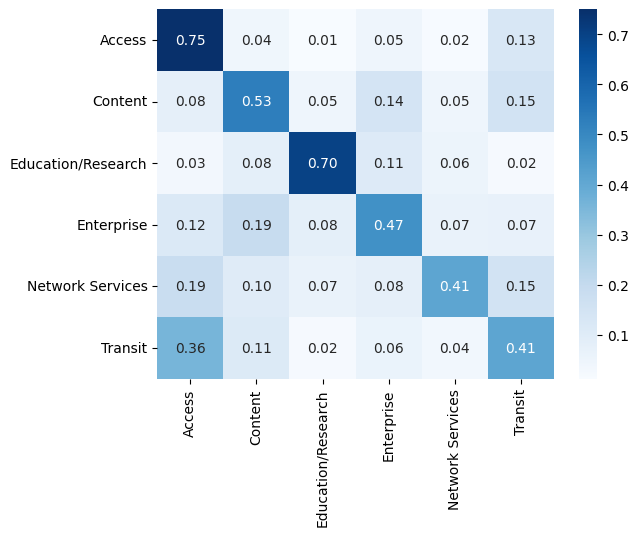

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_te, y_pred, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.show()

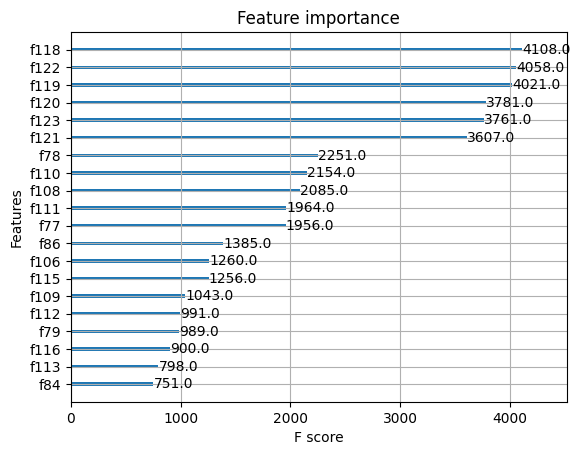

In [69]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features=20)
plt.show()


In [61]:
import numpy as np
def check_nan(name, X):
    bad = ~np.isfinite(X).all()
    print(f"[{name}] finite={not bad}, shape={X.shape}")
    return bad

bad1 = check_nan("Xnum_trB_pre", Xnum_trB_pre)
bad2 = check_nan("P_text_trB",   P_text_trB)
bad3 = check_nan("Xnum_te_pre",  Xnum_te_pre)
bad4 = check_nan("P_text_te",    P_text_te)
# Wenn True: Quelle finden, z. B. mit np.where(~np.isfinite(...))


[Xnum_trB_pre] finite=False, shape=(5970, 118)
[P_text_trB] finite=True, shape=(5970, 6)
[Xnum_te_pre] finite=False, shape=(4975, 118)
[P_text_te] finite=True, shape=(4975, 6)


In [67]:
# === CatBoost Early-Fusion (statt XGBoost) ===
from catboost import CatBoostClassifier, Pool
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Sicherheitsnetz: ±Inf -> NaN (CatBoost kann NaN, aber kein Inf)
def sanitize(X):
    X = np.array(X, dtype=float, copy=True)
    X[~np.isfinite(X)] = np.nan
    return X

X_ef_tr_s = sanitize(X_ef_tr)
X_ef_te_s = sanitize(X_ef_te)

# Class Weights wie zuvor
counts = Counter(y_trB)
max_count = max(counts.values())
sample_weight = np.array([max_count / counts[y] for y in y_trB], dtype=float)

train_pool = Pool(X_ef_tr_s, y_trB, weight=sample_weight)
valid_pool = Pool(X_ef_te_s, y_te)

cb = CatBoostClassifier(
    loss_function="MultiClass",
    learning_rate=0.05,
    depth=6,                 # 4–8 testen
    l2_leaf_reg=3.0,
    iterations=4000,         # groß + early stopping
    random_seed=42,
    od_type="Iter",          # Early Stopping
    od_wait=50,
    verbose=100
)

cb.fit(train_pool, eval_set=valid_pool)

# Test
y_pred = cb.predict(X_ef_te_s).astype(int).ravel()
y_prob = cb.predict_proba(X_ef_te_s)

print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
print(classification_report(y_te, y_pred, target_names=label_names if label_names else None))


0:	learn: 1.7511471	test: 1.7513675	best: 1.7513675 (0)	total: 14.1ms	remaining: 56.3s
100:	learn: 1.1274752	test: 1.1839975	best: 1.1839975 (100)	total: 1.36s	remaining: 52.6s
200:	learn: 1.0102796	test: 1.1333581	best: 1.1333581 (200)	total: 2.71s	remaining: 51.1s
300:	learn: 0.9215874	test: 1.1030860	best: 1.1030860 (300)	total: 4.07s	remaining: 50s
400:	learn: 0.8540654	test: 1.0879352	best: 1.0879352 (400)	total: 5.42s	remaining: 48.7s
500:	learn: 0.7939181	test: 1.0792037	best: 1.0791780 (495)	total: 6.86s	remaining: 47.9s
600:	learn: 0.7423347	test: 1.0709512	best: 1.0709349 (599)	total: 8.21s	remaining: 46.4s
700:	learn: 0.6971765	test: 1.0657482	best: 1.0657135 (699)	total: 9.56s	remaining: 45s
800:	learn: 0.6579557	test: 1.0611820	best: 1.0611820 (800)	total: 10.9s	remaining: 43.6s
900:	learn: 0.6247706	test: 1.0569369	best: 1.0569134 (899)	total: 12.2s	remaining: 42s
1000:	learn: 0.5915443	test: 1.0542699	best: 1.0541446 (994)	total: 13.6s	remaining: 40.6s
1100:	learn: 0.560